## Setup

In [1]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage.io import imsave, imread

In [3]:
from os import mkdir
from os.path import exists

## Set directory and session information

In [4]:
from thunder.images import fromtif, frombinary
from showit import image

In [4]:
# neurofinder data
directory = '/groups/freeman/freemanlab/from_tier2/Nick/neurofinder/neurofinder.02.00'
data = fromtif(directory + '/images', ext='tiff', engine=sc)

In [5]:
# kayvon data
directory = '/groups/freeman/freemanlab/from_tier2/Nick/kayvon/kd035_102616'
data = fromtif(directory + '/images', ext='tif', nplanes=1, engine=sc)

In [5]:
# large field data layer 4 data
directory = '/groups/freeman/freemanlab/from_tier2/Nick/mesoscope/000011'
data = frombinary(directory + '/images', engine=sc)

In [6]:
data

Images
mode: spark
dtype: int16
shape: (9302, 884, 896)

In [9]:
data = data[:1000,:,:]

In [7]:
mean = data.mean().toarray()

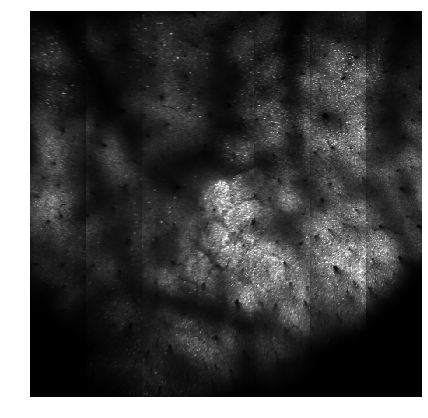

In [8]:
image(mean, clim=(0, 2000));

In [17]:
imsave('/groups/svoboda/home/sofroniewn/data/tmp/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

### registration

In [7]:
from mesoscope.registrations import register, register_blocks, register_blocks_piecewise

In [15]:
data_r, shifts = register(data)
mean_r = data_r.mean().toarray()

In [11]:
data_rb = register_blocks(data, size=(32, 32))
mean_rb = data_rb.mean().toarray()

In [12]:
data_rb = register_blocks(data_rb, size=(32, 32))
mean_rb = data_rb.mean().toarray()

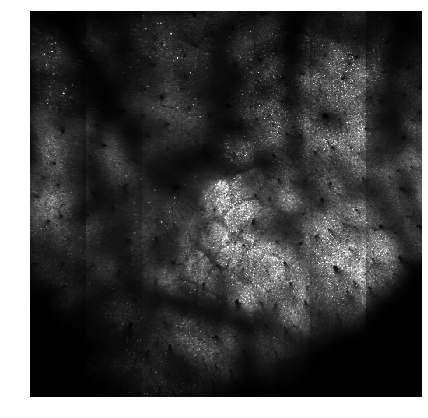

In [16]:
image(mean_rb, clim=(0, 2000));

In [13]:
imsave('/groups/svoboda/home/sofroniewn/data/tmp/mean_rb232.tif', mean_rb.astype('float32'), plugin='tifffile', photometric='minisblack')

In [21]:
if not exists(directory + '/summary'):
    mkdir(directory + '/summary')

In [22]:
imsave(directory + '/summary/mean.tif', mean.astype('float32'), plugin='tifffile', photometric='minisblack')

### extraction

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from mesoscope.CC import CC
from mesoscope.models import overlay, filter_shape

In [21]:
diameter = 11
algorithm = CC(diameter=diameter, clip_limit=0.04, theshold=0.2, sigma_blur=1, boundary=(1,1))
unmerged = algorithm.fit(data)

/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint16
  "%s to %s" % (dtypeobj_in, dtypeobj))
/misc/local/python-2.7.11/lib/python2.7/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


In [24]:
model = unmerged.merge(overlap=0.20, max_iter=3, k_nearest=10)
model = filter_shape(model, min_diameter = 0.7*diameter, max_diameter = 1.3*diameter, min_eccentricity = 0.2)

In [16]:
localcorr = data.localcorr(diameter)

In [ ]:
imsave(directory + '/summary/localcorr.tif', localcorr.astype('float32'), plugin='tifffile', photometric='minisblack')

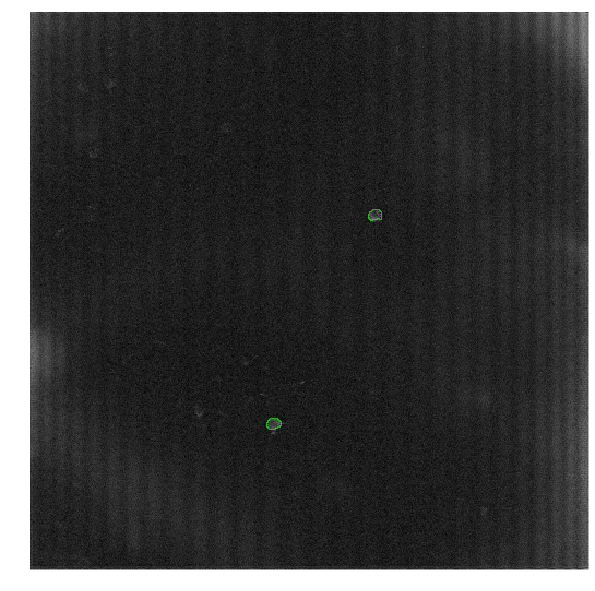

In [25]:
blend = overlay(model, image=localcorr, threshold=5, correct=False)
fig = plt.figure(figsize=[10,10])
ax = plt.axes()
image(blend, ax=ax)
plt.xlim([0, blend.shape[1]]);
plt.ylim([blend.shape[0], 0]);

In [58]:
if not exists(directory + '/regions'):
    mkdir(directory + '/regions')

In [59]:
model.save(directory + '/regions/regions-cc.json')

In [72]:
imsave(directory + '/summary/regions-lc.tif', (255*blend).astype('uint8'), plugin='tifffile', photometric='rgb')

### traces

In [23]:
from mesoscope.traces import dff

In [24]:
traces = dff(data, model)

In [26]:
traces.tobinary(directory + '/traces', overwrite=True)

In [27]:
t = traces.toarray()

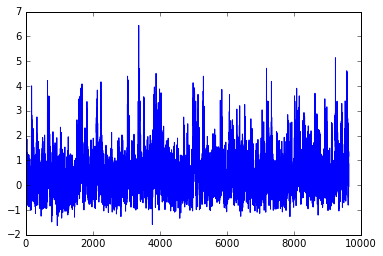

In [28]:
plt.plot(t[0]);

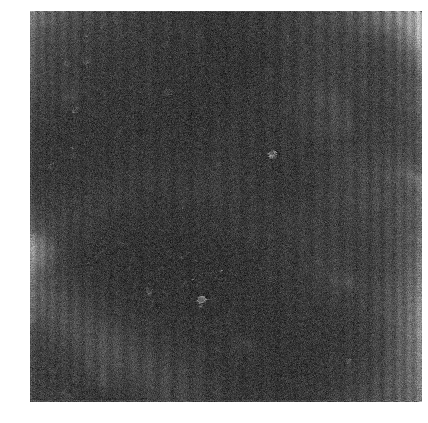

In [17]:
image(localcorr);

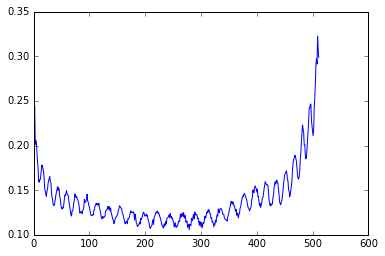

In [19]:
plt.plot(localcorr.mean(axis=0))